In [1]:
#Rep: https://github.com/vibhor-github/length-of-stay.git
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import pandas as pd
from functools import lru_cache

In [2]:
seed = 29
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# Define data path
DATA_PATH = "/Users/priyank.jain/Desktop/temp/"
prev_value_map = {}


In [3]:
train_y_df = pd.read_csv(DATA_PATH + 'train_listfile.csv') 
train_files = train_y_df["stay"].unique().tolist()
val_y_df = pd.read_csv(DATA_PATH + 'train_listfile.csv') 
val_files = val_y_df["stay"].unique().tolist()
train_y_min , train_y_max = train_y_df.y_true.describe(percentiles = [0.03, 0.97])[["3%","97%"]].to_list()
val_y_min , val_y_max = val_y_df.y_true.describe(percentiles = [0.03, 0.97])[["3%","97%"]].to_list()
train_y_df = train_y_df [ (train_y_df.y_true > train_y_min) & (train_y_df.y_true < train_y_max)]
val_y_df = val_y_df [ (val_y_df.y_true > val_y_min) & (val_y_df.y_true < val_y_max)]

In [4]:
len(train_y_df["stay"].unique().tolist())

29061

In [5]:
np.random.choice(train_y_df["stay"].unique().tolist(), 5000, replace=False)

array(['17324_episode1_timeseries.csv', '24461_episode1_timeseries.csv',
       '69169_episode1_timeseries.csv', ...,
       '425_episode1_timeseries.csv', '154_episode1_timeseries.csv',
       '61855_episode1_timeseries.csv'], dtype='<U30')

In [6]:
default_value_map = {"Capillary refill rate": 0.0,
    "Diastolic blood pressure": 59.0,
    "Fraction inspired oxygen": 0.21,
    "Glascow coma scale eye opening": 4,
    "Glascow coma scale motor response": 6,
    "Glascow coma scale total": 15,
    "Glascow coma scale verbal response": 5,
    "Glucose": 128.0,
    "Heart Rate": 86,
    "Height": 170.0,
    "Mean blood pressure": 77.0,
    "Oxygen saturation": 98.0,
    "Respiratory rate": 19,
    "Systolic blood pressure": 118.0,
    "Temperature": 36.6,
    "Weight": 81.0,
    "pH": 7.4}

In [7]:
replacement_map = {
    "Glascow coma scale eye opening":{
        "1 No Response" : 1,
        "No Response" : 1,
        "2 To pain" : 2,
        "To Pain" : 2,
        "3 To speech" : 3,
        "To Speech" : 3,
        "4 Spontaneously" : 4,
        "Spontaneously" : 4,
        "None" : 5
    },
    "Glascow coma scale motor response":{
        "1 No Response": 1,
        "2 Abnorm extensn" : 2,
        "Abnormal extension": 2,
        "3 Abnorm flexion": 3,
        "Abnormal Flexion": 3,
        "4 Flex-withdraws" : 4,
        "Flex-withdraws": 4,
        "5 Localizes Pain": 5,
        "Localizes Pain": 5,
        "6 Obeys Commands": 6,
        "Obeys Commands": 6,
        "No response" : 7,
    },
    "Glascow coma scale verbal response":{
        "1 No Response" :1,
        "No Response":1,
        "2 Incomp sounds": 2,
        "Incomprehensible sounds":2,
        "3 Inapprop words":3,
        "Inappropriate Words":3,
        "4 Confused":4,
        "Confused":4,
        "5 Oriented":5,
        "Oriented":5,
        "No Response-ETT":6,
        "1.0 ET/Trach":7
    }
}

In [8]:
def to_np(elem):
    return np.concatenate([np.array(i) for i in elem])

In [9]:
def cleanup(episode_df):
    episode_df["Glascow coma scale eye opening"] = episode_df["Glascow coma scale eye opening"].apply(lambda x: replacement_map["Glascow coma scale eye opening"][x] if x in replacement_map["Glascow coma scale eye opening"] else x)
    episode_df["Glascow coma scale motor response"] = episode_df["Glascow coma scale motor response"].apply(lambda x: replacement_map["Glascow coma scale motor response"][x] if x in replacement_map["Glascow coma scale motor response"] else x)
    episode_df["Glascow coma scale verbal response"] = episode_df["Glascow coma scale verbal response"].apply(lambda x: replacement_map["Glascow coma scale verbal response"][x] if x in replacement_map["Glascow coma scale verbal response"] else x)


In [10]:
def process_capillary_refill_rate(person_id, value, colname):
    if value is not None and not np.isnan(value):
        prev_value_map[person_id][colname] = value
        return value
    if person_id in prev_value_map and colname in prev_value_map[person_id] and prev_value_map[person_id][colname] is not None:
        prev = prev_value_map[person_id][colname]
    else:
        prev = default_value_map[colname]
    return prev

In [11]:
def fill_missing_values(pateint_id, episode_df):
     prev_value_map[pateint_id] = {}
     episode_df["Capillary refill rate"] = episode_df["Capillary refill rate"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Capillary refill rate"))
     episode_df["Diastolic blood pressure"] = episode_df["Diastolic blood pressure"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Diastolic blood pressure"))
     episode_df["Fraction inspired oxygen"] = episode_df["Fraction inspired oxygen"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Fraction inspired oxygen"))
     episode_df["Glascow coma scale eye opening"] = episode_df["Glascow coma scale eye opening"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Glascow coma scale eye opening"))
     episode_df["Glascow coma scale motor response"] = episode_df["Glascow coma scale motor response"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Glascow coma scale motor response"))
     episode_df["Glascow coma scale total"] = episode_df["Glascow coma scale total"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Glascow coma scale total"))
     episode_df["Glascow coma scale verbal response"] = episode_df["Glascow coma scale verbal response"].apply(lambda x: process_capillary_refill_rate(pateint_id,  x, "Glascow coma scale verbal response"))
     episode_df["Glucose"] = episode_df["Glucose"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Glucose"))
     episode_df["Heart Rate"] = episode_df["Heart Rate"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Heart Rate"))
     episode_df["Mean blood pressure"] = episode_df["Mean blood pressure"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Mean blood pressure"))
     episode_df["Height"] = episode_df["Height"].apply(lambda x: process_capillary_refill_rate(pateint_id,x, "Height"))
     episode_df["Oxygen saturation"] = episode_df["Oxygen saturation"].apply(lambda x: process_capillary_refill_rate(pateint_id,  x, "Oxygen saturation"))
     episode_df["Respiratory rate"] = episode_df["Respiratory rate"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Respiratory rate"))
     episode_df["Systolic blood pressure"] = episode_df["Systolic blood pressure"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Systolic blood pressure"))
     episode_df["Temperature"] = episode_df["Temperature"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Temperature"))
     episode_df["Weight"] = episode_df["Weight"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Weight"))
     episode_df["pH"] = episode_df["pH"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "pH"))
     del prev_value_map[pateint_id]

In [12]:
def get_window_indices(data_len, window_len = 4):
    i = 0
    indices = []
    while i <= data_len-window_len:
        indices.append([i+j for j in range(window_len)])
        i +=1
    return indices

In [13]:
def get_one_hot_encoding(val, dim):
    encoding = [0 for i in range (dim)]
    encoding[val-1] = 1
    return encoding

In [14]:
get_window_indices(7,5)

[[0, 1, 2, 3, 4], [1, 2, 3, 4, 5], [2, 3, 4, 5, 6]]

In [15]:
def preprocess(path):
    x_path = DATA_PATH +'/'+path+'/'
    X = torch.empty(0,34,5)
    Y = torch.empty(0,)
    index_data = []
    y_df = pd.read_csv(DATA_PATH + "train" +'_listfile.csv') 
    data_files = os.listdir(x_path)
    print(data_files)
    i = 0
    for data_file in data_files:
        data_info = data_file.split("_")
        print(data_file)
        if data_file.endswith(".csv"):
            episode_df = pd.read_csv(x_path + data_file)
            cleanup(episode_df)
            fill_missing_values(data_file, episode_df)
            episode_df["H_IDX"] = episode_df.Hours.apply(np.floor).astype('int32')
            episode_df = episode_df.groupby(by = "H_IDX").agg("last")
            gcser = pd.DataFrame(episode_df["Glascow coma scale eye opening"].astype('int32').apply(get_one_hot_encoding, args=(5,)).to_list())
            gcsmr = pd.DataFrame(episode_df["Glascow coma scale motor response"].astype('int32').apply(get_one_hot_encoding, args=(7,)).to_list())
            gcsvr = pd.DataFrame(episode_df["Glascow coma scale verbal response"].astype('int32').apply(get_one_hot_encoding, args=(7,)).to_list()) 
            episode_df = pd.concat((episode_df, gcser, gcsmr, gcsvr), axis=1)
            episode_df = episode_df.drop(["Glascow coma scale eye opening", "Glascow coma scale motor response", "Glascow coma scale verbal response"], axis=1)
            #episode_df = episode_df[episode_df.Hours>=5].reset_index(drop = True)
            temp_y = y_df[y_df.stay == data_file].sort_values(by = "period_length").reset_index(drop = True)
            temp_y = temp_y[["period_length", "y_true"]].set_index("period_length")
            episode_df = episode_df.join(temp_y, how = "inner").reset_index(drop = True)
            episode_df = episode_df.dropna().reset_index(drop = True)
            
            if(len(episode_df) >0):
                indices = get_window_indices(len(episode_df), window_len=5)
                windows = []
                y_values = []
                for j , idx in enumerate(indices):
                    window = episode_df.loc[idx]
                    y_values.append(window.loc[idx[-1]].y_true)
                    windows.append(window.drop("y_true", axis=1).transpose().values.astype(np.float32))
                    index_data.append((i, data_info[0], data_info[1], j))
                    i = i+1
                t_windows = torch.tensor(windows)
                t_y_values = torch.tensor(y_values)
                X = torch.cat((X, t_windows), 0)
                Y = torch.cat((Y, t_y_values), 0)
    index_df = pd.DataFrame(index_data)
    index_df.columns = ["idx", "patient_id", "episode", "window_idx"]
    index_df.to_csv(path+"_index.csv", index= False)
    return (X, Y, index_df)

In [16]:
X_train, Y_train , index_df = preprocess('train')

['.DS_Store', '10010_episode1_timeseries.csv', '10003_episode1_timeseries.csv', '10014_episode1_timeseries.csv', '10007_episode1_timeseries.csv', '1000_episode1_timeseries.csv', '10022_episode1_timeseries.csv']
.DS_Store
10010_episode1_timeseries.csv
10003_episode1_timeseries.csv
10014_episode1_timeseries.csv
10007_episode1_timeseries.csv
1000_episode1_timeseries.csv
10022_episode1_timeseries.csv


In [17]:
@lru_cache(maxsize = 10)
def load_notes_embeddings(patient_id, episode):
    file = "/Users/priyank.jain/Desktop/temp/notes/{}_{}_notes_bert_window5-1_tensor.parquet".format(patient_id, episode)
    df = pd.read_parquet(file, engine = "pyarrow")
    return torch.tensor(np.stack([np.stack(x) for x in df["TEXT_WINDOW_EMBEDDING"].iloc[0]]), dtype = torch.float32)

In [18]:
X_train.shape

torch.Size([890, 34, 5])

In [54]:
index_df

,idx,patient_id,episode,window_idx
0,0,10010,episode1,0
1,1,10010,episode1,1
2,2,10010,episode1,2
3,3,10010,episode1,3
4,4,10010,episode1,4
...,...,...,...,...
885,885,1000,episode1,815
886,886,1000,episode1,816
887,887,1000,episode1,817
888,888,1000,episode1,818


In [55]:
from torch.utils.data import Dataset

class EpisodeDataset(Dataset):
    
    def __init__(self, obs, los, index_df):
        self.x = obs
        self.y = los
        self.index = index_df
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        idx = self.index[self.index.idx == index]
        #print("Index is ", idx)
        #print("patient_id ", idx.iat[0,1])
        #print("episode ", idx.iat[0,2])
        pe_notes = load_notes_embeddings(idx.iat[0,1], idx.iat[0,2])
        #print(pe_notes.shape)
        notes = pe_notes[idx.iat[0,3]]
        return (self.x[index], notes, self.y[index])
        
X_train, Y_train, index_df_trn = preprocess('train')
train_dataset = EpisodeDataset(X_train, Y_train, index_df_trn)
X_val, Y_val, index_df_val = preprocess('val')
val_dataset = EpisodeDataset(X_val, Y_val, index_df_val)

['.DS_Store', '10010_episode1_timeseries.csv', '10003_episode1_timeseries.csv', '10014_episode1_timeseries.csv', '10007_episode1_timeseries.csv', '1000_episode1_timeseries.csv', '10022_episode1_timeseries.csv']
.DS_Store
10010_episode1_timeseries.csv
10003_episode1_timeseries.csv
10014_episode1_timeseries.csv
10007_episode1_timeseries.csv
1000_episode1_timeseries.csv
10022_episode1_timeseries.csv
['10021_episode1_timeseries.csv', '10017_episode1_timeseries.csv', '10013_episode1_timeseries.csv']
10021_episode1_timeseries.csv
10017_episode1_timeseries.csv
10013_episode1_timeseries.csv


In [56]:
Y_train.shape

torch.Size([890])

In [57]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)                              
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=32, shuffle=False)                                         

In [27]:
for data in train_dataset:
    print(data[1])
    break

tensor([[ 0.1960,  0.0660,  0.0069,  ...,  0.1463,  0.4188, -0.0990],
        [ 0.1463, -0.0668, -0.1357,  ..., -0.2370, -0.0274, -0.3128],
        [ 0.2593, -0.0207, -0.3413,  ..., -0.4827, -0.1116, -0.2412],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [64]:

class PhysioNet(nn.Module):
    def __init__(self):
        super(PhysioNet, self).__init__()
        #input shape 34 * 8
        #output shape 16 * 8
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride = 1)
        #input shape 16 * 8
        #output shape 32 * 8
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride = 1)
        #input shape 32 * 8
        #output shape 16 * 4
        self.pool1 = nn.MaxPool2d(2,2)
        #input shape 16 * 4
        #output shape 32 * 4
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride = 1)
        self.fc1 = nn.Linear(64*17*2, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        #self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        print("In PhysioNet")
        x = x.unsqueeze(1)
        print(x.shape)
        x = F.leaky_relu(self.conv1(x))
        print(x.shape)
        x = F.leaky_relu(self.conv2(x))
        print(x.shape)
        x = self.pool1(x)
        print(x.shape)
        x = F.leaky_relu(self.conv3(x))
        print(x.shape)
        x = x.view(-1, 64*17*2)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        print(x.shape)
        x = F.leaky_relu(self.fc2(x))
        print(x.shape)
        x = F.leaky_relu(self.fc3(x))
        print(x.shape)
        #x = self.fc4(x)
        return x


In [65]:
model = PhysioNet()
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate )

In [61]:
from sklearn.metrics import mean_squared_error
def eval_model(model, val_loader):
    model.eval()
    all_y_true = torch.DoubleTensor()
    all_y_pred = torch.DoubleTensor()
    for x, y in val_loader:
        y_hat = model(x)
        all_y_true = torch.cat((all_y_true, y.to('cpu')), dim=0)
        all_y_pred = torch.cat((all_y_pred,  y_hat.to('cpu')), dim=0)
    mse= mean_squared_error(all_y_true.detach().numpy(), all_y_pred.detach().numpy())
    print(f"mse: {mse:.3f}")
    return mse

In [ ]:
import statistics
def train(model, train_loader, n_epochs):
    train_losses = []
    for epoch in range(n_epochs):
        loss_per_epoch = []
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            #print(x.shape)
            y_hat = model(x)
            #print(y_hat.shape)
            y_hat = y_hat.view(y_hat.shape[0]).double()
            #print(y_hat.shape)
            #print(y_hat)
            #print(y.shape)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()
            loss_per_epoch.append(train_loss)
            #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
        #eval_model(model, val_loader)
        epoch_loss = statistics.mean(loss_per_epoch)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, epoch_loss))
        train_losses.append(epoch_loss)
    return train_losses

    
# number of epochs to train the model
n_epochs = 250
train_losses = train(model, train_loader, n_epochs)

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
#len(train_losses)

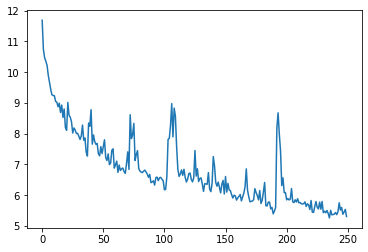

In [30]:
from math import log
#train_losses = [log(y) for y in train_losses]
plt.plot(train_losses)
#plt.show()
plt.savefig('test.png')

In [28]:
torch.save(model.state_dict(), DATA_PATH+"/model.pt")

In [29]:
model_loaded = EpisiodeCNN()
model_loaded.load_state_dict(torch.load(DATA_PATH+"/model.pt"))
eval_model(model_loaded, train_loader)

mse: 33476.029


33476.02936491705

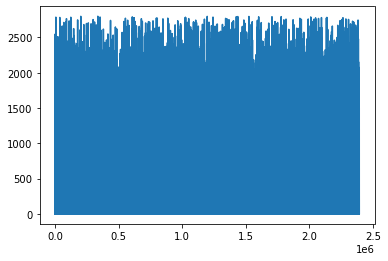

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
plt.plot(train_y_df.y_true.to_list())
plt.show()

In [66]:
class NotesNet(nn.Module):
    def __init__(self):
        super(NotesNet, self).__init__()
        #input shape 1 * 80 * 768
        #output shape 16 * 40 * 384
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2, stride = 2)
        #input shape 16 * 40 * 384
        #output shape 16 * 20 * 192
        self.pool2 = nn.MaxPool2d(2,2)
        #input shape 16 * 20 * 192
        #output shape 32 * 20 * 192
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride = 1)
        #input shape 32 * 20 * 192
        #output shape 64 * 10 * 96
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, stride = 2)
        self.fc1 = nn.Linear(64*10*96, 2048)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)

    def forward(self, x):
        #input is of shape (batch_size=32, 3, 224, 224) if you did the dataloader right
        x = x.unsqueeze(1)
        print(x.shape)
        x = x.to(torch.float32)
        print(x.dtype)
        x = F.leaky_relu(self.conv1(x))
        #print(x.shape)
        x = self.pool2(x)
        #print(x.shape)
        x = F.leaky_relu(self.conv3(x))
        #print(x.shape)
        x = F.leaky_relu(self.conv4(x))
        #print(x.shape)
        x = x.view(-1, 64*10*96)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        #print(x.shape)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        #print(x.shape)
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [80]:
class EpisodeNet(nn.Module):
    def __init__(self):
        super(EpisodeNet, self).__init__()
        self.physio_net = PhysioNet()
        self.notes_net = NotesNet()
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, physio_x, notes_x):
        physio_x = self.physio_net(physio_x)
        #print("physio_x.shape", physio_x.shape)
        notes_x = self.notes_net(notes_x)
        #print("notes_x.shape", notes_x.shape)
        x = torch.cat((physio_x, notes_x), axis = -1)
        #print("notes_x.shape", notes_x.shape)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

In [77]:
model = EpisodeNet()
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate )

In [79]:
import statistics
def train(model, train_loader, n_epochs):
    train_losses = []
    for epoch in range(n_epochs):
        loss_per_epoch = []
        model.train()
        for physio_x, notes_x, y in train_loader:
            optimizer.zero_grad()
            #print(x.shape)
            y_hat = model(physio_x, notes_x)
            #print(y_hat.shape)
            y_hat = y_hat.double()
            y_hat = y_hat.squeeze(1)
            #print(y_hat.shape)
            #print(y_hat.shape)
            #print(y_hat)
            #print(y.shape)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()
            loss_per_epoch.append(train_loss)
            #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
        #eval_model(model, val_loader)
        epoch_loss = statistics.mean(loss_per_epoch)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, epoch_loss))
        train_losses.append(epoch_loss)
    return train_losses

    
# number of epochs to train the model
n_epochs = 5
train_losses = train(model, train_loader, n_epochs)

e([32, 32])
physio_x.shape torch.Size([32, 32])
torch.Size([32, 1, 80, 768])
torch.float32
notes_x.shape torch.Size([32, 32])
notes_x.shape torch.Size([32, 32])
In PhysioNet
torch.Size([32, 1, 34, 5])
torch.Size([32, 16, 34, 5])
torch.Size([32, 32, 34, 5])
torch.Size([32, 32, 17, 2])
torch.Size([32, 64, 17, 2])
torch.Size([32, 256])
torch.Size([32, 128])
torch.Size([32, 32])
physio_x.shape torch.Size([32, 32])
torch.Size([32, 1, 80, 768])
torch.float32
notes_x.shape torch.Size([32, 32])
notes_x.shape torch.Size([32, 32])
In PhysioNet
torch.Size([32, 1, 34, 5])
torch.Size([32, 16, 34, 5])
torch.Size([32, 32, 34, 5])
torch.Size([32, 32, 17, 2])
torch.Size([32, 64, 17, 2])
torch.Size([32, 256])
torch.Size([32, 128])
torch.Size([32, 32])
physio_x.shape torch.Size([32, 32])
torch.Size([32, 1, 80, 768])
torch.float32
notes_x.shape torch.Size([32, 32])
notes_x.shape torch.Size([32, 32])
In PhysioNet
torch.Size([32, 1, 34, 5])
torch.Size([32, 16, 34, 5])
torch.Size([32, 32, 34, 5])
torch.Size(